## Make plots for thesis for comparing synthetic data

We make plots comparing the synthetic data sets with the real data sets for AD, CH and DI. 

In [1]:
import numpy as np
import pandas as pd
import random

import sys
import os
# Tricks for loading data and libraries from parent directories. 
parent = os.path.abspath("..")
sys.path.insert(1, parent)
print(sys.path)

# Custom styles and sizing for matplotlib.
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("tex.mplstyle")
from plotting_utils import set_size

from sklearn import metrics # plot_roc_curve.

from Data import Data, CustomDataset, ToTensor

# Calculate correlations between categorical variables
# using Theil's U statistic.
# https://en.wikipedia.org/wiki/Uncertainty_coefficient
from dython.nominal import associations

# Set seeds for reproducibility. 
seed = 1234
np.random.seed(seed)
random.seed(seed)

['/home/ajo/gitRepos/master_thesis/plotting', '/home/ajo/gitRepos/master_thesis', '/home/ajo/anaconda3/envs/master/lib/python38.zip', '/home/ajo/anaconda3/envs/master/lib/python3.8', '/home/ajo/anaconda3/envs/master/lib/python3.8/lib-dynload', '', '/home/ajo/.local/lib/python3.8/site-packages', '/home/ajo/anaconda3/envs/master/lib/python3.8/site-packages']


In [2]:
cat_feat_AD = ["workclass","marital_status","occupation","relationship", \
                        "race","sex","native_country"]
num_feat_AD = ["age","fnlwgt","education_num","capital_gain","capital_loss","hours_per_week"]

cat_feat_CH = ["Geography", "Gender", "HasCrCard", "IsActiveMember"]
num_feat_CH = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "EstimatedSalary"]

cat_feat_DI = []
num_feat_DI = ["num_pregnant", "plasma", "dbp", "skin", "insulin", "bmi", "pedi", "age"]

# Load the real data into the scope. 
# Could also simply load the no_NA datasets via csv or pickle instead of this complicated method. 
train_AD = pd.read_csv("../splitted_data/AD/AD_train.csv", index_col = 0)
test_AD = pd.read_csv("../splitted_data/AD/AD_test.csv", index_col = 0)
valid_AD = pd.read_csv("../splitted_data/AD/AD_valid.csv", index_col = 0)
data_AD = {"Train":train_AD, "Test":test_AD, "Valid":valid_AD}

train_CH = pd.read_csv("../splitted_data/CH/CH_train.csv", index_col = 0)
test_CH = pd.read_csv("../splitted_data/CH/CH_test.csv", index_col = 0)
valid_CH = pd.read_csv("../splitted_data/CH/CH_valid.csv", index_col = 0)
data_CH = {"Train":train_CH, "Test":test_CH, "Valid":valid_CH}

train_DI = pd.read_csv("../splitted_data/DI/DI_train.csv", index_col = 0)
test_DI = pd.read_csv("../splitted_data/DI/DI_test.csv", index_col = 0)
valid_DI = pd.read_csv("../splitted_data/DI/DI_valid.csv", index_col = 0)
data_DI = {"Train":train_DI, "Test":test_DI, "Valid":valid_DI}

Data_object_AD = Data(data_AD, cat_features = cat_feat_AD, num_features = num_feat_AD,
                        seed = seed, already_splitted_data=True, scale_version="quantile", valid = True)
Data_object_CH = Data(data_CH, cat_features = cat_feat_CH, num_features = num_feat_CH,
                        seed = seed, already_splitted_data=True, scale_version="quantile", valid = True)
Data_object_DI = Data(data_DI, cat_features = cat_feat_DI, num_features = num_feat_DI,
                        seed = seed, already_splitted_data=True, scale_version="quantile", valid = True)

real_AD = Data_object_AD.get_original_data()
real_CH = Data_object_CH.get_original_data()
real_DI = Data_object_DI.get_original_data()

adult_data = pd.read_pickle("../loading_data/AD/AD_no_NA.pkl")
churn_data = pd.read_pickle("../loading_data/CH/CH_no_NA.pkl")
diabetes_data = pd.read_pickle("../loading_data/DI/DI_no_NA.pkl")

In [3]:
# Check that my statement above is correct. 
print(all(adult_data[real_AD.columns.tolist()] == real_AD.sort_index()))
print(all(churn_data[real_CH.columns.tolist()] == real_CH.sort_index()))
print(all(diabetes_data[real_DI.columns.tolist()] == real_DI.sort_index()))

True
True
True


In [4]:
# Load the synthetic data into the scope. 
diffusion_AD = pd.read_csv("../synthetic_data/AD_Gaussian_multinomial_diffusion"+str(seed)+".csv", index_col = 0)
mcce_AD = pd.read_csv("../synthetic_data/AD_from_trees"+str(seed)+".csv", index_col = 0)
tvae_AD = pd.read_csv("../synthetic_data/AD_TVAE"+str(seed)+".csv", index_col = 0)

diffusion_CH = pd.read_csv("../synthetic_data/CH_Gaussian_multinomial_diffusion"+str(seed)+".csv", index_col = 0)
mcce_CH = pd.read_csv("../synthetic_data/CH_from_trees"+str(seed)+".csv", index_col = 0)
tvae_CH = pd.read_csv("../synthetic_data/CH_TVAE"+str(seed)+".csv", index_col = 0)

diffusion_DI = pd.read_csv("../synthetic_data/DI_Gaussian_diffusion"+str(seed)+".csv", index_col = 0)
mcce_DI = pd.read_csv("../synthetic_data/DI_from_trees"+str(seed)+".csv", index_col = 0)
tvae_DI = pd.read_csv("../synthetic_data/DI_TVAE"+str(seed)+".csv", index_col = 0)

In [5]:
# Make sure that the true and synthetic datasets have the same order for the columns.
diffusion_AD = diffusion_AD[real_AD.columns.tolist()]
mcce_AD = mcce_AD[real_AD.columns.tolist()]
tvae_AD = tvae_AD[real_AD.columns.tolist()]

diffusion_CH = diffusion_CH[real_CH.columns.tolist()]
mcce_CH = mcce_CH[real_CH.columns.tolist()]
tvae_CH = tvae_CH[real_CH.columns.tolist()]

diffusion_DI = diffusion_DI[real_DI.columns.tolist()]
mcce_DI = mcce_DI[real_DI.columns.tolist()]
tvae_DI = tvae_DI[real_DI.columns.tolist()]

## Calculate "correlations" between all the features

In [6]:
# Calculate "correlations".

# Hyperparameters for "associations".
nom_nom_assoc = "theil"
num_num_assoc = "pearson"

diffusion_corr_AD = associations(diffusion_AD, nominal_columns=cat_feat_AD, 
            numerical_columns=num_feat_AD, nom_nom_assoc=nom_nom_assoc,
            num_num_assoc=num_num_assoc, compute_only = True)["corr"]

mcce_corr_AD = associations(mcce_AD, nominal_columns=cat_feat_AD, 
            numerical_columns=num_feat_AD, nom_nom_assoc=nom_nom_assoc,
            num_num_assoc=num_num_assoc, compute_only = True)["corr"]

tvae_corr_AD = associations(tvae_AD, nominal_columns=cat_feat_AD, 
            numerical_columns=num_feat_AD, nom_nom_assoc=nom_nom_assoc,
            num_num_assoc=num_num_assoc, compute_only = True)["corr"]

true_corr_AD = associations(real_AD, nominal_columns=cat_feat_AD, 
            numerical_columns=num_feat_AD, nom_nom_assoc=nom_nom_assoc,
            num_num_assoc=num_num_assoc, compute_only = True)["corr"]

corr_abs_diff_diffusion_AD = np.abs(true_corr_AD - diffusion_corr_AD)
corr_abs_diff_mcce_AD = np.abs(true_corr_AD - mcce_corr_AD)
corr_abs_diff_tvae_AD = np.abs(true_corr_AD - tvae_corr_AD)

In [7]:
diffusion_corr_CH = associations(diffusion_CH, nominal_columns=cat_feat_CH, 
            numerical_columns=num_feat_CH, nom_nom_assoc=nom_nom_assoc,
            num_num_assoc=num_num_assoc, compute_only = True)["corr"]

mcce_corr_CH = associations(mcce_CH, nominal_columns=cat_feat_CH, 
            numerical_columns=num_feat_CH, nom_nom_assoc=nom_nom_assoc,
            num_num_assoc=num_num_assoc, compute_only = True)["corr"]

tvae_corr_CH = associations(tvae_CH, nominal_columns=cat_feat_CH, 
            numerical_columns=num_feat_CH, nom_nom_assoc=nom_nom_assoc,
            num_num_assoc=num_num_assoc, compute_only = True)["corr"]

true_corr_CH = associations(real_CH, nominal_columns=cat_feat_CH, 
            numerical_columns=num_feat_CH, nom_nom_assoc=nom_nom_assoc,
            num_num_assoc=num_num_assoc, compute_only = True)["corr"]

corr_abs_diff_diffusion_CH = np.abs(true_corr_CH - diffusion_corr_CH)
corr_abs_diff_mcce_CH = np.abs(true_corr_CH - mcce_corr_CH)
corr_abs_diff_tvae_CH = np.abs(true_corr_CH - tvae_corr_CH)

In [8]:
diffusion_corr_DI = associations(diffusion_DI, nominal_columns=cat_feat_DI, 
            numerical_columns=num_feat_DI, nom_nom_assoc=nom_nom_assoc,
            num_num_assoc=num_num_assoc, compute_only = True)["corr"]

mcce_corr_DI = associations(mcce_DI, nominal_columns=cat_feat_DI, 
            numerical_columns=num_feat_DI, nom_nom_assoc=nom_nom_assoc,
            num_num_assoc=num_num_assoc, compute_only = True)["corr"]

tvae_corr_DI = associations(tvae_DI, nominal_columns=cat_feat_DI, 
            numerical_columns=num_feat_DI, nom_nom_assoc=nom_nom_assoc,
            num_num_assoc=num_num_assoc, compute_only = True)["corr"]

true_corr_DI = associations(real_DI, nominal_columns=cat_feat_DI, 
            numerical_columns=num_feat_DI, nom_nom_assoc=nom_nom_assoc,
            num_num_assoc=num_num_assoc, compute_only = True)["corr"]

corr_abs_diff_diffusion_DI = np.abs(true_corr_DI - diffusion_corr_DI)
corr_abs_diff_mcce_DI = np.abs(true_corr_DI - mcce_corr_DI)
corr_abs_diff_tvae_DI = np.abs(true_corr_DI - tvae_corr_DI)

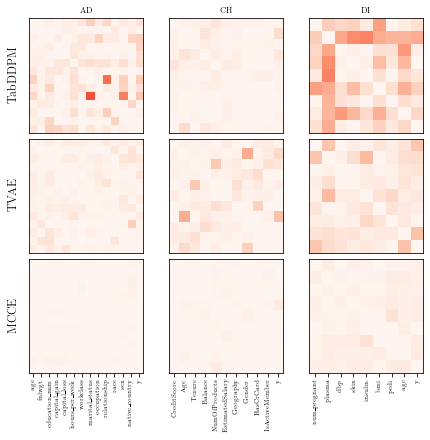

In [9]:
fig, ax = plt.subplots(nrows = 3,ncols = 3, figsize = (6,6))#, figsize = set_size())

# AD
##############################
ax[0,0].imshow(corr_abs_diff_diffusion_AD, cmap = "Reds", vmin = 0, vmax = 1)
ax[0,0].set_title("AD")
ax[0,0].xaxis.set_ticklabels([])
ax[0,0].yaxis.set_ticklabels([])
#ax[0,0].set_yticks(range(len(real_AD.columns.tolist())))
#ax[0,0].yaxis.set_ticklabels(real_AD.columns.tolist())
ax[0,0].tick_params(which='major', bottom=False, left=False)
ax[0,0].set_ylabel("TabDDPM")

ax[1,0].imshow(corr_abs_diff_tvae_AD, cmap = "Reds", vmin = 0, vmax = 1)
#ax[1,0].set_title("AD")
ax[1,0].xaxis.set_ticklabels([])
ax[1,0].yaxis.set_ticklabels([])
#ax[1,0].set_yticks(range(len(real_AD.columns.tolist())))
#ax[1,0].yaxis.set_ticklabels(real_AD.columns.tolist())
ax[1,0].tick_params(which='major', bottom=False, left=False)
ax[1,0].set_ylabel("TVAE")

ax[2,0].imshow(corr_abs_diff_mcce_AD, cmap = "Reds", vmin = 0, vmax = 1)
#ax[2,0].set_title("AD")
#ax[2,0].xaxis.set_ticklabels([])
ax[2,0].yaxis.set_ticklabels([])
ax[2,0].set_xticks(range(len(real_AD.columns.tolist())))
ax[2,0].xaxis.set_ticklabels(real_AD.columns.tolist(), rotation = 90)
ax[2,0].tick_params(which='major', bottom=True, left=False)
ax[2,0].set_ylabel("MCCE")
###############################

# CH
##############################
ax[0,1].imshow(corr_abs_diff_diffusion_CH, cmap = "Reds", vmin = 0, vmax = 1)
ax[0,1].set_title("CH")
ax[0,1].xaxis.set_ticklabels([])
ax[0,1].yaxis.set_ticklabels([])
#ax[0,1].set_yticks(range(len(real_CH.columns.tolist())))
#ax[0,1].yaxis.set_ticklabels(real_CH.columns.tolist())
ax[0,1].tick_params(which='major', bottom=False, left=False)
#ax[0,1].set_ylabel("TabDDPM")

ax[1,1].imshow(corr_abs_diff_tvae_CH, cmap = "Reds", vmin = 0, vmax = 1)
#ax[1,1].set_title("CH")
ax[1,1].xaxis.set_ticklabels([])
ax[1,1].yaxis.set_ticklabels([])
#ax[1,1].set_yticks(range(len(real_CH.columns.tolist())))
#ax[1,1].yaxis.set_ticklabels(real_CH.columns.tolist())
ax[1,1].tick_params(which='major', bottom=False, left=False)
#ax[1,1].set_ylabel("TVAE")

ax[2,1].imshow(corr_abs_diff_mcce_CH, cmap = "Reds", vmin = 0, vmax = 1)
#ax[2,1].set_title("CH")
#ax[2,1].xaxis.set_ticklabels([])
ax[2,1].yaxis.set_ticklabels([])
ax[2,1].set_xticks(range(len(real_CH.columns.tolist())))
ax[2,1].xaxis.set_ticklabels(real_CH.columns.tolist(), rotation = 90)
ax[2,1].tick_params(which='major', bottom=True, left=False)
#ax[2,1].set_ylabel("MCCE")
############################

# DI
###########################
ax[0,2].imshow(corr_abs_diff_diffusion_DI, cmap = "Reds", vmin = 0, vmax = 1)
ax[0,2].set_title("DI")
ax[0,2].xaxis.set_ticklabels([])
ax[0,2].yaxis.set_ticklabels([])
#ax[0,2].set_yticks(range(len(real_DI.columns.tolist())))
#ax[0,2].yaxis.set_ticklabels(real_DI.columns.tolist())
ax[0,2].tick_params(which='major', bottom=False, left=False)
#ax[0,2].set_ylabel("TabDDPM")

ax[1,2].imshow(corr_abs_diff_tvae_DI, cmap = "Reds", vmin = 0, vmax = 1)
#ax[1,2].set_title("DI")
ax[1,2].xaxis.set_ticklabels([])
ax[1,2].yaxis.set_ticklabels([])
#ax[1,2].set_yticks(range(len(real_DI.columns.tolist())))
#ax[1,2].yaxis.set_ticklabels(real_DI.columns.tolist())
ax[1,2].tick_params(which='major', bottom=False, left=False)
#ax[1,2].set_ylabel("TVAE")

ax[2,2].imshow(corr_abs_diff_mcce_DI, cmap = "Reds", vmin = 0, vmax = 1)
#ax[2,2].set_title("DI")
#ax[2,2].xaxis.set_ticklabels([])
ax[2,2].yaxis.set_ticklabels([])
ax[2,2].set_xticks(range(len(real_DI.columns.tolist())))
ax[2,2].xaxis.set_ticklabels(real_DI.columns.tolist(), rotation = 90)
ax[2,2].tick_params(which='major', bottom=True, left=False)
#ax[2,2].set_ylabel("MCCE")
############################

plt.tight_layout()
#plt.subplots_adjust(wspace=0.1, hspace = 0.1)
#plt.savefig("../plots/all_correlations.pdf", format="pdf", bbox_inches = "tight") 

# COULD SIMPLY ADD ANOTHER ROW HERE FOR TabDDPM-joint distribution!!!
# That is a better solution I believe!